# Perceptron Algorithm

Make Animated Perceptron Algorithm inspired by Lesson 2.10 [Intro to Deep Learning with PyTorch](https://www.udacity.com/course/deep-learning-pytorch--ud188) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from IPython.display import HTML

sns.set_style('darkgrid')
%matplotlib inline

## Import Data

In [2]:
df = pd.read_csv('../data/2_10.csv')
df.head()

,x1,x2,y
0,0.78051,-0.063669,1
1,0.28774,0.291390,1
2,0.40714,0.178780,1
3,0.29230,0.421700,1
4,0.50922,0.352560,1


`x1`-column -- x1-feature, x1-coordinate in our case

`x2`-column -- x2-feature, x2-coordinate in our case

`y`-column  -- class label, ground truth values

## Plot Our Data

Let's have plot our data. Since our data already sorted by class we can do the following:

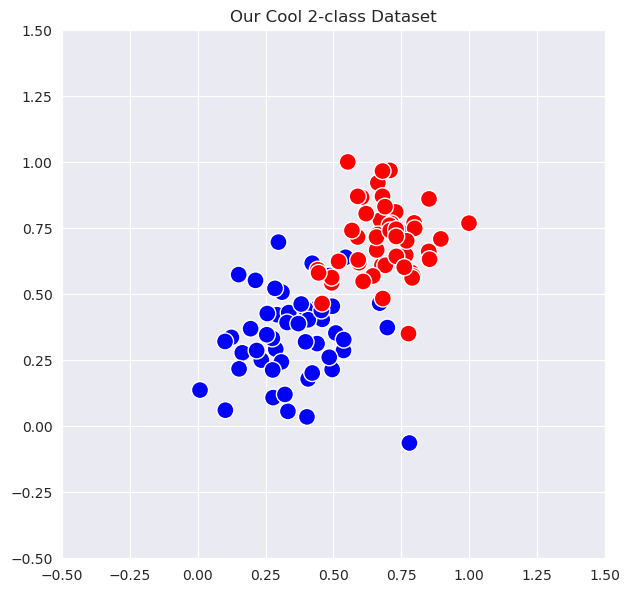

In [3]:
# extract columns 
x1, x2, y = df['x1'], df['x2'], df['y'] 

# list of colors. Our :50 items are '1'-class and other 50: - '0'-class
# we have two classes so we will use 2 colors: 'b' - blue and 'r' - red
colors = ['b'] * 50 + ['r'] * 50

plt.figure(figsize=(7, 7), dpi=100, facecolor='w')  # This controls figure size

plot = plt.scatter(x1, x2, c=colors, edgecolors='w', s=150)  # to plot scatterplot
plt.title('Our Cool 2-class Dataset')  # add title
plt.xlim([-.5, 1.5])  # set min and max value for x-axis to be shown
plt.ylim([-.5, 1.5]);  # the same for y-axis

## Perceptron Activation, AKA Step Function, AKA Heaviside Function

Let's do some ML code :) First code part that makes prediction on X, so it will give us `y_hat` values

In [4]:
def prediction(X, W, b):
    """
    Perceptron activation step function. Takes feature vector X, weights vector W and b. 
    
    Arguments:
    X -- array of shape (1, 2), Feature vecto. Ex: [[x1, x2]] 
    W -- array of shape (1, 2), Weights vector. Ex: [[w1, w2]]
    b -- array of shape (1, 1), Bias. Ex: [[1]]
            
    Returns:
    y_hat -- array of shape (1, 1), predicted y value (predicted class)
    """

    z = X @ W.T + b  # Linear combination, @ - matrix multiplication symbol in python
    y_hat = np.where(z >= 0, 1, 0)  # turns every element in array that is >=0 to 1 <0 to 0 
    return y_hat

Let's play with it to see how it works (If it really works)


In [5]:
X = np.arange(4).reshape(1, 4)  # our dummy X
W = np.random.random_sample((1, 4))  # random weights
b = np.random.rand(1)  # random bias

y_hat = prediction(X, W, b)
print(f'Our X: {X}')
print(f'Our W: {W}')
print(f'Our b: {b}')
print(f'Our y_hat: {y_hat}')

Our X: [[0 1 2 3]]
Our W: [[0.95296562 0.67813784 0.82111643 0.23669462]]
Our b: [0.43835429]
Our y_hat: [[1]]


In [6]:
# more predictable example:

X = np.ones(4).reshape(1, 4) * 7 * [-1, 1, -1, 1]  # our dummy X
W = np.ones((1, 4))  # ones weights
b = np.zeros((1, 1))  # zero bias

# our X @ W.T + b expected to be 0, so y_hat should be 1
y_hat = prediction(X, W, b)

print(f'Our X: {X}')
print(f'Our W: {W}')
print(f'Our b: {b}')
print(f'Our y_hat: {y_hat}')

Our X: [[-7.  7. -7.  7.]]
Our W: [[1. 1. 1. 1.]]
Our b: [[0.]]
Our y_hat: [[1]]


It works! Let's make bias to be negative

In [7]:
# another more predictable example:

X = np.ones(4).reshape(1, 4) * 7 * [-1, 1, -1, 1]  # our dummy X
W = np.ones((1, 4))  # ones weights
b = np.ones((1, 1)) * -1  # negative bias

# our X @ W.T + b expected to be -1, so y_hat should be 0
y_hat = prediction(X, W, b)

print(f'Our X: {X}')
print(f'Our W: {W}')
print(f'Our b: {b}')
print(f'Our y_hat: {y_hat}')

Our X: [[-7.  7. -7.  7.]]
Our W: [[1. 1. 1. 1.]]
Our b: [[-1.]]
Our y_hat: [[0]]


## Perceptron Weights Updating Rule

Seems `prediction` works fine. Let's go next!

Here we will implement one step of perceptron algorithm. It works in the following way:
0. First we pass X array - it represents our dataset and has shape of (100, 2). Where each row is training sample and 2 columns are features (x1, x2 coordinates in our case).
y - array of shape (100, y) represents labels, ground truth class values. Also we pass W, b - weights array and bias that are need to be updated AFTER PROCESSING SINGLE TRAINING EXAMPLE!!! NOT AFTER BATCH OR EPOCH! That's important!
1. Takes first sample from X `xi`, `yi` - where `xi` - feature vector of shape (1, 2) and `yi` - ground truth class (0 or 1).
2. Makes prediction for `xi` using `prediction` func.
3. Compare that value to ground truth value `yi`.
4. If it differs does the following: if predicted class `y_hat` is 0 then update weights and bias by addition, if `y_hat` is 1 - update them by subtraction. If `y_hat` == `y` - takes the next sample from `X`.
5. Takes the next sample from `X`. And does step 2-4. and so on...
6. Until it looped over the whole dataset - then returns Weights, bias and error (in our case) - single epoch is done.
7. Repeats step 1-6 for `num_epochs`.

In [8]:
def perceptron_step(X, y, W, b, learning_rate=0.01):
    """
    Perceptron step function. Takes feature vector X, weights vector W and b. 
    
    Arguments:
    X -- array of shape (N, 2), Training dataset of N training examples. Ex: (100, 2)
    y -- array of shape (N, 1), Class ground truth values for X of size N Ex: (100, 2)
    W -- array of shape (1, 2), Weights. Ex: [[w1, w2]]
    b -- array of shape (1, 1), Bias. Ex: [[1]]
    learning_rate -- float, Learning rate.
            
    Returns:
    W, b, e - updated Weights, of shape (1, 2), updated bias (1, 1) and amount of errors
    """

    e = 0  # var to store amount of errors NOT realted to algorithm
    # Looping over dataset
    for xi, yi in zip(X, y):
        y_hat = prediction(xi, W, b)  # Make prediction on single sample xi
        # checking the result of prediction:
        if y_hat != yi:  # if it bad - updating the weights and bias, if good - go to next sample
            e += 1  # increment error value
            # Updating weights and bias:
            if y_hat == 0:
                W += xi * learning_rate
                b += learning_rate  # NOTE: here we do not use xi
            elif y_hat == 1:
                W -= xi * learning_rate
                b -= learning_rate  # NOTE: here we do not use xi
    return W, b, e

## Perceptron Train Function

The last function is our training loop:

In [9]:
def train(X, y, learning_rate=0.01, num_epochs=100):
    """
    Perceptron step function. Takes feature vector X, weights vector W and b. 
    
    Arguments:
    X -- array of shape (N, 2), Training dataset of N training examples. Ex: (100, 2)
    y -- array of shape (N, 1), Class ground truth values for X of size N Ex: (100, 2)
    learning_rate -- float, Learning rate.
    nums_epochs -- int, Total amount of training epochs
    
    Returns:
    history -- list of tuples of len = num_epochs, each tuple contains:
    trained weigths, bias and error in following format:
    (-W[0, 0] / W[0, 1], -b / W[0, 1], error)
    (float, float, int)
    """

    W = np.random.random_sample((1, 2))  # initilize weigths randomly
    b = np.zeros((1, 1))  # initilize bias as zero
    history = []  # here we will store training history W, b and errror for each epoch
    # Main loop:
    for epoch in range(num_epochs):
        W, b, e = perceptron_step(X, y, W, b, learning_rate)  # perform one training epoch
        history.append((float(-W[0, 0] / W[0, 1]), float(-b / W[0, 1]), e))  # storing results for epoch
    return history

## Perceptron Training

In [10]:
np.random.seed(42)  # set a random seed,  42 - as in Lesson 2.10

learning_rate = 0.001  # set the learning rate
num_epochs = 200  # set total number of epochs

# Our dataset X - features (x1, x2 - coords), y - class labels
X = np.array(df[['x1', 'x2']])
y = np.array(df['y']).reshape(y.shape[0], 1)  # reshape to (N, 1) just to be sure

history = train(X, y, learning_rate=learning_rate, num_epochs=num_epochs)

## Plot Training History

Here we plot each boundary line from `history` list for each epoch

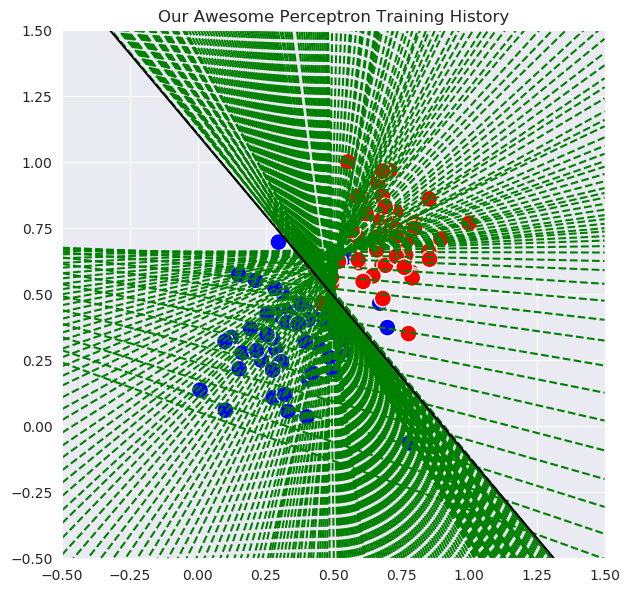

In [11]:
plt.figure(figsize = (7, 7), dpi = 100, facecolor = 'w')

x1, x2, y = df['x1'], df['x2'], df['y']  # Our dataset
colors = ['b'] * 50 + ['r'] * 50  # colors for plot
plt.scatter(x1, x2, c=colors, edgecolors='w', s=150)  # scatterplot

xx1 = np.linspace(-.5, 1.5, 2)  # create x-axis values, see numpy doc for more :)
# Boundary line xx2 will be:
# xx2 = xx1*a + b where a, b - weights and bias unpacked from tuple from history list  
# See below:

for i in range(len(history)):
    if i != len(history)-1:
        color, linestyle = ['green', '--']  # Make first epochs to be green and dashed
    else:
        color, linestyle = ['black', '-']  # Make the last epoch to be another color an dstyle

    a, b, _ = history[i]  # unpack weights from epoch tuple
    xx2 = xx1 * a + b  # values for y-axis (boundary line equation)
    plt.plot(xx1, xx2, linestyle=linestyle, color=color)  # plot epoch boundary line

plt.title('Our Awesome Perceptron Training History')  # add title
plt.xlim([-.5, 1.5])  # set min and max value for x-axis to be shown
plt.ylim([-.5, 1.5]);  # the same for y-axis

## Animate Training History

Cool! Let's make some animation in Jupyter!

To do that we need to do some changes in our previous cell:

In [ ]:
fig = plt.figure(figsize = (7, 7), dpi = 100, facecolor = 'w')

x1, x2, y = df['x1'], df['x2'], df['y']  # Our dataset
data_size = len(y)
colors = ['b'] * 50 + ['r'] * 50  # colors for plot
plt.scatter(x1, x2, c=colors, edgecolors='w', s=150)  # scatterplot

xx1 = np.linspace(-.5, 1.5, 2)

plots = []
for i in range(len(history)):
    a, b, e = history[i]  # unpack weigts and error from epoch tuple
    xx2 = xx1 * a + b  # values for y-axis (boundary line equation)
    plot = plt.plot(xx1, xx2, linestyle=linestyle, color=color)  # plot epoch boundary line
    text = f'Epoch: {i + 1} - Accuracy: {(data_size - e) / data_size * 100} %'  # Our title text
    te = plt.text(90, 90, text)
    an = plt.annotate(text, xy=(0.3, 1.05), xycoords='axes fraction')
    plots.append(plot + [te, an])

plt.xlim([-.5, 1.5])  # set min and max value for x-axis to be shown
plt.ylim([-.5, 1.5])  # the same for y-axis

ani = animation.ArtistAnimation(fig, plots, interval=50, blit=False, repeat_delay=100)

# To run animation in browser:

HTML(ani.to_jshtml())

## Export Animation to Video File

In [13]:
# To save the animation you need ffmpeg binary
# for Ubuntu run sudo apt-get install ffmpeg

ani.save('animated_plot.mp4')